# Chapter 3
## Statistial Experiments and Significance Testing

import required Python Packages


In [17]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [18]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = path().resolve() / 'data'

data csv dengan data python berbeda folder jadi lebih minimalis atau rapih aja.

In [32]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSION_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISIH_CSV = DATA / 'imanishi_data.csv'

#### Figure 3-1
The Classical statisscial inference pipline
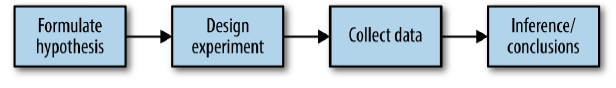

# Resampling
The result is a total of
36 sessions for the two different presentations, 21 for page A and 15 for page B. Using
ggplot, we can visually compare the session times using side-by-side boxplots:

In [20]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

session_times.head(5)

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


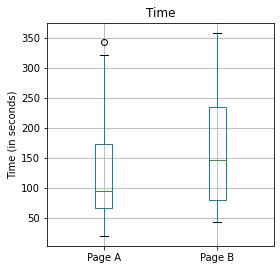

In [21]:
# The pandas boxplot command uses the keyword argument by to create the figure:
ax = session_times.boxplot(by='Page', column='Time',
                          figsize=(4, 4))

ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [22]:
# we filter the pandas data frame first by page and then determine the mean of the Time column:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b, mean_a)

162.0 126.33333333333333



The follwing code is diffrent to the R version. idx_A and idx_B are reversed.

In [23]:
# Permutation test example with stickinees
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-13.590476190476181


Page B has session times that are greater than those of page A by 35.67 seconds, on
average. The question is whether this difference is within the range of what random
chance might produce, i.e., is statistically significant. One way to answer this is to
apply a permutation test—combine all the session times together and then repeatedly
shuffle and divide them into groups of 21 (recall that nA = 21 for page A) and 15
(nB = 15 for page B).

To apply a permutation test, we need a function to randomly assign the 36 session
times to a group of 21 (page A) and a group of 15 (page B).


This function works by sampling (without replacement) nB indices and assigning
them to the B group; the remaining nA indices are assigned to group A. The difference
between the two means is returned. Calling this function R = 1,000 times and
specifying nA = 21 and nB = 15 leads to a distribution of differences in the session
times that can be plotted as a histogram. In R this is done as follows using the hist
function:

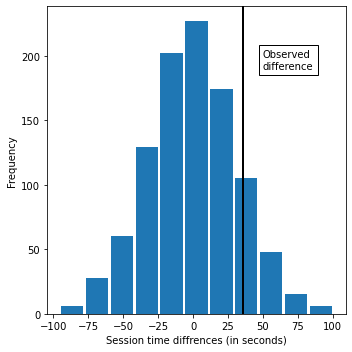

In [24]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time diffrences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Figure 3-4. Frequency distribution for session time differences between pages A and B;the vertical line shows the observed difference


The histogram, in Figure 3-4 shows that mean difference of random permutations
often exceeds the observed difference in session times (the vertical line). 
As the simulation uses random numbers, the percentage will vary. For example, in the
Python version, we got 12.1%:

In [25]:
# print(np.mean(perm_diffs > mean_b - mean_a)) 
# https://github.com/gedeck/practical-statistics-for-data-scientists/issues/26
print(np.mean(np.array(perm_diffs) > mean_b - mean_a))

0.121


# Staistical Significance and P-Values

Statistical significance is how statisticians measure whether an experiment (or even a
study of existing data) yields a result more extreme than what chance might produce.

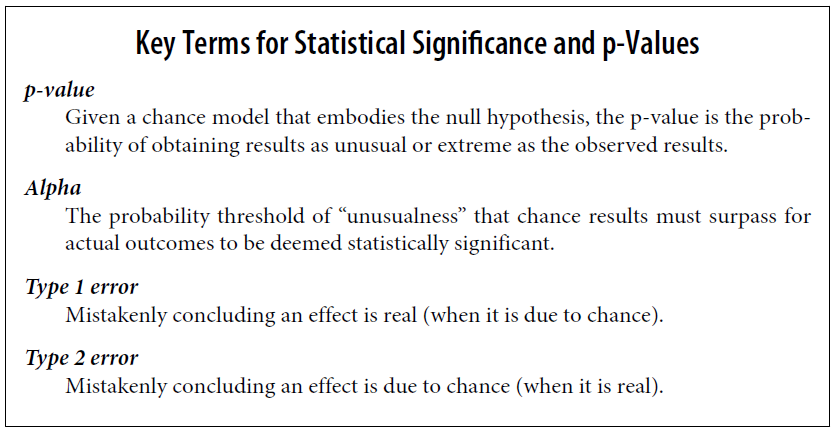

#### Tabel 3-2 Tabel for ecommerence experiment results
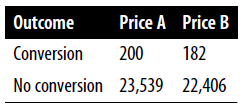

Price A converts almost 5% better than price B (0.8425% = 200/(23539+200)*100,
versus 0.8057% = 182/(22406+182)*100—a difference of 0.0368 percentage points),
big enough to be meaningful in a high-volume business. We have over 45,000 data
points here, and it is tempting to consider this as “big data,” not requiring tests of
statistical significance (needed mainly to account for sampling variability in small
samples).

“If the two prices share the same conversion rate, could chance variation
produce a difference as big as 5%?”
1. Put cards labeled 1 and 0 in a box: this represents the supposed shared conversion
rate of 382 ones and 45,945 zeros = 0.008246 = 0.8246%.
2. Shuffle and draw out a resample of size 23,739 (same n as price A), and record
how many 1s.
3. Record the number of 1s in the remaining 22,588 (same n as price B).
4. Record the difference in proportion of 1s.
5. Repeat steps 2–4.
6. How often was the difference >= 0.0368?

See the histogram of 1,000 resampled results in Figure 3-5: as it happens, in this case
the observed difference of 0.0368% is well within the range of chance variation.

Observed difference: 0.0368%


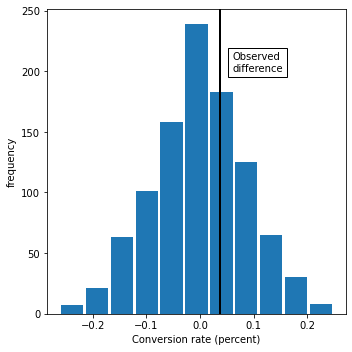

In [26]:
random.seed(1)
obs_pct_diff = 100 * (200  / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)
    
perm_diffs = [100 * perm_fun(conversion, 23739, 22588)
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('frequency')

plt.tight_layout()
plt.show()

#### Figure 3-5. Frequency distribution for the difference in conversion rates between prices A and B

## P-Value
Simply looking at the graph is not a very precise way to measure statistical significance,
so of more interest is the p-value.

We can estimate a pvalue
from our permutation test by taking the proportion of times that the permutation
test produces a difference equal to or greater than the observed difference

if `np.mean` is applied to a list of booleans, it gives the percentage of how often True was found in the list(#True/#Toltal).

In [27]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


The p-value is 0.308, which means that we would expect to achieve a result as
extreme as this, or a more extreme result, by random chance over 30% of the time.

In this case, we didn’t need to use a permutation test to get a p-value. Since we have a
binomial distribution, we can approximate the p-value.

The method scipy.stats.chi2_contingency takes the values as shown in Table 3-2:

In [28]:
survivors = np.array([[200, 23739 - 200], [182, 22588 -182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p_value for single sided test: {p_value / 2:.4f}')

p_value for single sided test: 0.3498


The normal approximation yields a p-value of 0.3498, which is close to the p-value
obtained from the permutation test.

## t-Tests
There are numerous types of significance tests, depending on whether the data comprises
count data or measured data, how many samples there are, and what’s being
measured.

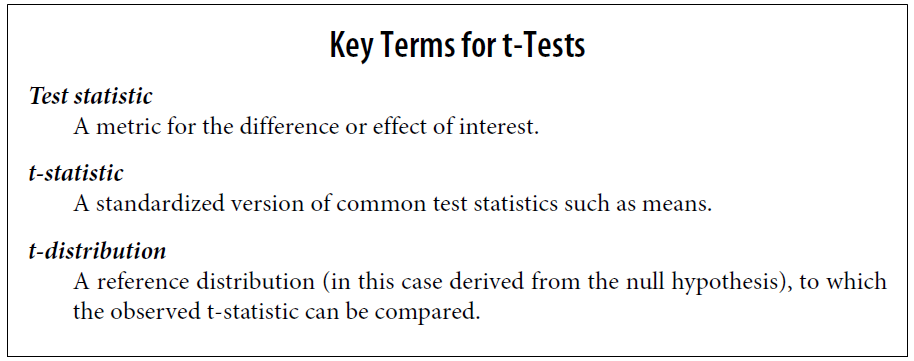

In [29]:
# The function scipy.stats.ttest_ind can be used in Python
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


The alternative hypothesis is that the session time mean for page A is less than that
for page B. The p-value of 0.1408 is fairly close to the permutation test p-values of
0.121 and 0.126

In [30]:
tstat, pvalue, df = sm.stats.ttest_ind(
        session_times[session_times.Page == 'Page A'].Time,
        session_times[session_times.Page == 'Page B'].Time,
        usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


## Anova (Analysis of Variance)

Suppose that, instead of an A/B test, we had a comparison of multiple groups, say
A/B/C/D, each with numeric data. The statistical procedure that tests for a statistically
significant difference among the groups is called analysis of variance, or ANOVA.

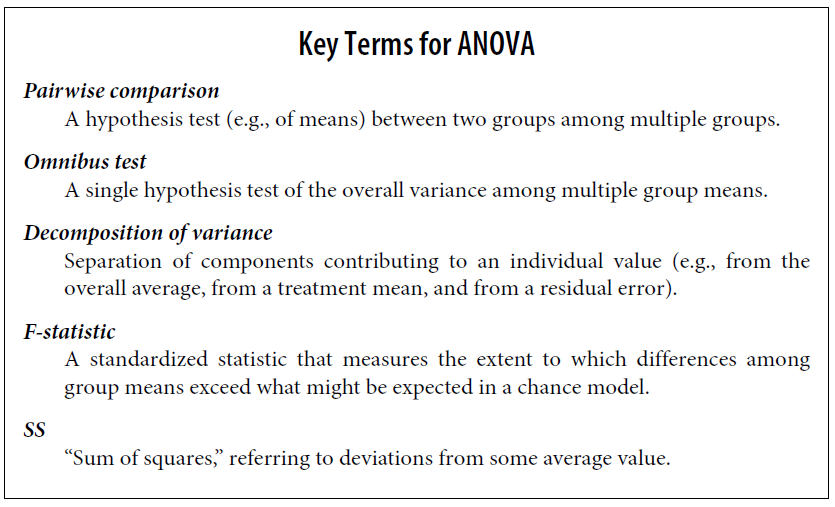

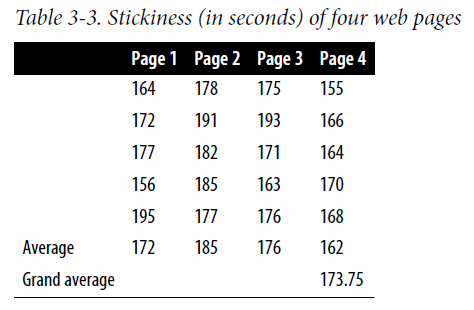


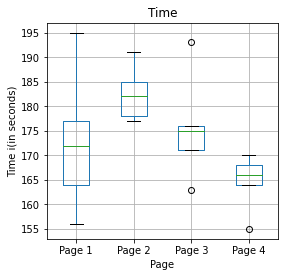

In [37]:
# Figure 3-6 Boxplots of the four groups show considerable differences among them
four_sessions = pd.read_csv(FOUR_SESSION_CSV)
# four_session.head()
ax = four_sessions.boxplot(by='Page', column='Time',
                         figsize=(4, 4))

ax.set_xlabel('Page')
ax.set_ylabel('Time i(in seconds)')
plt.suptitle('')
plt.show()

The procedure used to test this is ANOVA. The basis for it can be seen in the following
resampling procedure (specified here for the A/B/C/D test of web page
stickiness):
1. Combine all the data together in a single box.
2. Shuffle and draw out four resamples of five values each.
3. Record the mean of each of the four groups.
4. Record the variance among the four group means.
5. Repeat steps 2–4 many (say, 1,000) times.

In [36]:
print(pd.read_csv(FOUR_SESSION_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [40]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
19.32000000000002


The p-value, given by Pr(Prob), is 0.09278. In other words, given the same underlying
stickiness, 9.3% of the time the response rate among four pages might differ as
much as was actually observed, just by chance. This degree of improbability falls
short of the traditional statistical threshold of 5%, so we conclude that the difference
among the four pages could have arisen by chance.

Pr(Prob) 0.07866666666666666


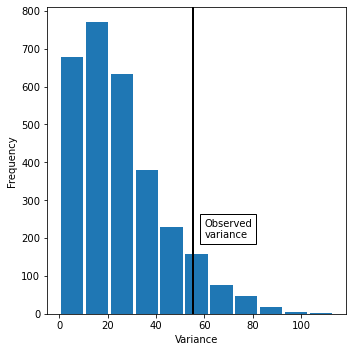

In [41]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## F-Statistic
Just like the t-test can be used instead of a permutation test for comparing the mean
of two groups, there is a statistical test for ANOVA based on the F-statistic. The Fstatistic
is based on the ratio of the variance across group means (i.e., the treatment
effect) to the variance due to residual error

We can compute an ANOVA table using statsmodel.

Df is “degrees of freedom,” Sum Sq is “sum of squares,” Mean Sq is “mean squares”
(short for mean-squared deviations), and F value is the F-statistic

In [44]:
# The statsmodels package provides an ANOVA implementation
model = smf.ols('Time ~ Page', data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [43]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time,
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)

print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


### Two-way anova only available with statsmodels
```
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

## Chi-Square Test
### Chi-Square Test: A Resampling Approach

In [45]:
# Table 3-4 
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


The headlines certainly appear to differ. Headline A returns nearly twice the click rate
of B. The actual numbers are small, though. A resampling procedure can test whether
the click rates differ to an extent greater than chance might cause. For this test, we
need to have the “expected” distribution of clicks, and in this case, that would be
under the null hypothesis assumption that all three headlines share the same click
rate, for an overall click rate of 34/3,000. Under this assumption, our contingency
table would look like Table 3-5.

In [46]:
# Tabel 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,

})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


We can test with this resampling algorithm:
1. Constitute a box with 34 ones (clicks) and 2,966 zeros (no clicks).
2. Shuffle, take three separate samples of 1,000, and count the clicks in each.
3. Find the squared differences between the shuffled counts and the expected
counts and sum them.
4. Repeat steps 2 and 3, say, 1,000 times.
5. How often does the resampled sum of squared deviations exceed the observed?
That’s the p-value

In [48]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                 for observe in row])
        # return sum of squares
        return np.sum(pearson_residuals)
    
expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6471
Resampled p-value: 0.4820


## Chi-Square Test:Statistical Theory

For a contingency table,
the degrees of freedom are related to the number of rows (r) and columns (c) as
follows:
`degrees of freedom = r − 1 × c − 1`
The chi-square distribution is typically skewed, with a long tail to the right

In [53]:
# use the function scipy.stats.chi2_contingency
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


## Figure chi-sq distribution
#### Figure 3-7 Chi-Square distribution with various degrees of freedom 

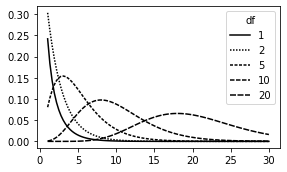

In [62]:
# Value of Chi-Square statistic
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x':x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10' : stats.chi2.pdf(x, df=10),
    'chi_20' : stats.chi2.pdf(x, df=20),
})

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()



## Fisher's Exact Test
The chi-square distribution is a good approximation of the shuffled resampling test
just described, except when counts are extremely low (single digits, especially five or
fewer). In such cases, the resampling procedure will yield more accurate p-values. In
fact, most statistical software has a procedure to actually enumerate all the possible
rearrangements (permutations) that can occur, tabulate their frequencies, and determine
exactly how extreme the observed result is. This is called Fisher’s exact test after
the great statistician R


Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler. 
```
stats.fisher_exact(clicks)
```

In [63]:
# stats.fisher_exact(clicks.values)

### Scienctific Fraud

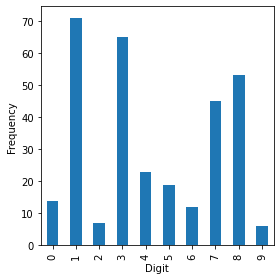

In [70]:
# Figure 3-8  Frequency histogram for imanishi kari lab Data
imanishi = pd.read_csv(IMANISIH_CSV)
#imanishi.head(10)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                          figsize=(4, 4))

ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Power and Sample Size

statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

For example, suppose current click-through rates are about 1.1%, and you are seeking
a 10% boost to 1.21%. So we have two boxes: box A with 1.1% ones (say, 110 ones and
9,890 zeros), and box B with 1.21% ones (say, 121 ones and 9,879 zeros). For starters,
let’s try 300 draws from each box (this would be like 300 “impressions” for each ad).
Suppose our first draw yields the following:

Box A: 3 ones

Box B: 5 ones

The statsmodels package contains several methods for power calculation. Here, we
use proportion_effectsize to calculate the effect size and TTestIndPower to solve
for the sample size:

In [71]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
                             alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


For example, suppose current click-through rates are still 1.1%, but we are now seeking
a 50% boost to 1.65%. So we have two boxes: box A still with 1.1% ones (say, 110
ones and 9,890 zeros), and box B with 1.65% ones (say, 165 ones and 9,868 zeros).
Now we’ll try 2,000 draws from each box. Suppose our first draw yields the following:

Box A: 19 ones

Box B: 34 ones

In [76]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
results = analysis.solve_power(effect_size=effect_size,
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)


Sample Size: 5488.408


We see that if we want a power of 80%, we
require a sample size of almost 120,000 impressions. If we are seeking a 50% boost
(p1=0.0165), the sample size is reduced to 5,500 impressions.

### Summary
The principles of experimental design—randomization of subjects into two or more
groups receiving different treatments—allow us to draw valid conclusions about how
well the treatments work. It is best to include a control treatment of “making no
change.” The subject of formal statistical inference—hypothesis testing, p-values,
t-tests, and much more along these lines—occupies much time and space in a traditional
statistics course or text, and the formality is mostly unneeded from a data science
perspective. However, it remains important to recognize the role that random
variation can play in fooling the human brain. Intuitive resampling procedures (permutation
and bootstrap) allow data scientists to gauge the extent to which chance
variation can play a role in their data analysis.